In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [2]:
# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jim/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
def create_uniform_grid(low, high, bins=(10, 10)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    print("Uniform grid: [<low>, <high>] / <bins> => <splits>")
    for l, h, b, splits in zip(low, high, bins, grid):
        print("    [{}, {}] / {} => {}".format(l, h, b, splits))
    return grid
    pass


In [4]:
def discretize(sample, grid):
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension

In [5]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

In [7]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        return tuple(discretize(state, self.state_grid))


    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(15, 15))   
q_agent = QLearningAgent(env, state_grid)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 15 => [-0.867 -0.733 -0.6   -0.467 -0.333 -0.2   -0.067  0.067  0.2    0.333  0.467  0.6    0.733  0.867]
    [-1.0, 1.0] / 15 => [-0.867 -0.733 -0.6   -0.467 -0.333 -0.2   -0.067  0.067  0.2    0.333  0.467  0.6    0.733  0.867]
Environment: <TimeLimit<AcrobotEnv<Acrobot-v1>>>
State space size: (15, 15)
Action space size: 3
Q table size: (15, 15, 3)


In [8]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)

Episode 20000/20000 | Max Average Score: -389.39

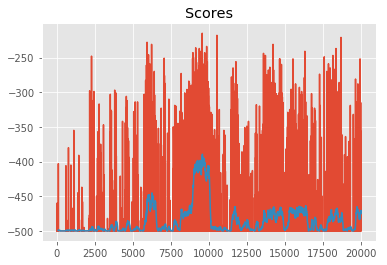

In [9]:
import pandas as pd
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

In [10]:
def run(agent, env, num_episodes=200000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores_200000 = run(q_agent, env)

Episode 200000/200000 | Max Average Score: -409.52

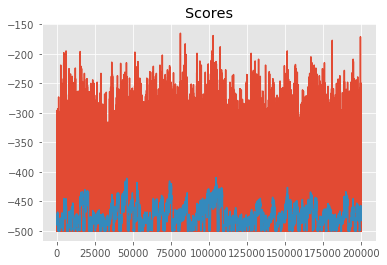

In [11]:
import pandas as pd
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores_200000)

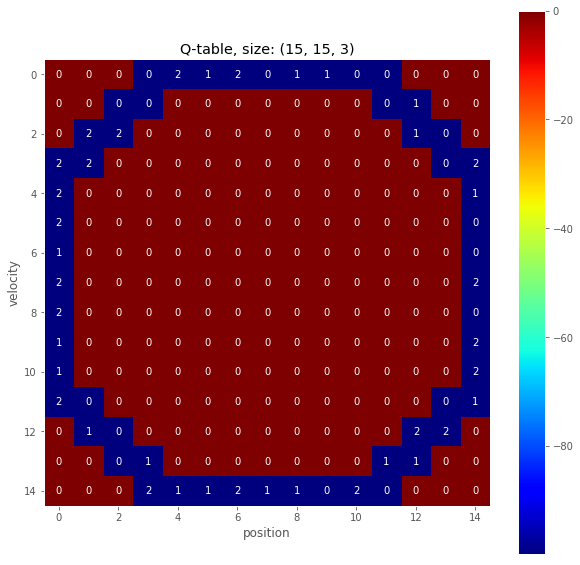

In [12]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(q_agent.q_table)